In [1]:
import sys
sys.path.append('..')

from tqdm import tqdm
import numpy as np
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from random import sample
from copy import deepcopy


from src.dips_selector import *
from src.data_loader import *
from src.baseline_functions import *
from src.runner import run_baselines
from src.utils import process_results
from src.visualize_results import bar_plot_compare,iteration_evolution_plot, adapted_boxplot
from src.data_loader import *

import torch
import torch.nn as nn

# for other selectors
from datagnosis.plugins.core.datahandler import DataHandler
from datagnosis.plugins.core.models.simple_mlp import SimpleMLP
from datagnosis.plugins import Plugins


# CUTRACT is Dlab and Dtest & SEER is D_unlabeled

In [2]:
import traceback
overall_result_dicts = []
overall_data_dicts = []
overall_model_dicts = []


dips_metric = 'aleatoric'
dips_ythresh = 0.2

algorithm_list=['Fully Supervised', 'Supervised_Learning','Pseudo_Labeling', 'UPS'] # swap PL for UPS if needed
        

seed=0
nest=100
prop_data=1
num_XGB_models=5
numTrials=10
numIters=5
upper_threshold=0.8
verbose=False
method = 'dips' # other selectors fine, loss, 

try:
    for i in tqdm(range(numTrials)):
        
        split_prop = 1
        df_feat_seer, df_label_seer, df_seer = get_data(dataset='seer', prop=1)
        df_feat_cutract, df_label_cutract, df_cutract = get_data(dataset='cutract', prop=split_prop, seed=seed)

    
        seed+=1

        print(f"Trial {i+1}/{numTrials}")
        results = {}
        data = {}
        models = {}

        x_train, x_test, y_train, y_test = train_test_split(
            df_feat_cutract, df_label_cutract, test_size=0.8, random_state=seed,
            stratify=df_label_cutract.values
        )

        _, x_unlabeled, _, y_unlabeled = train_test_split(
            df_feat_seer, df_label_seer, test_size=0.99, random_state=seed,
            stratify=df_label_seer.values
        )

        x_unlabeled, x_test, y_test, x_train, y_train = (
            np.asarray(x_unlabeled),
            np.asarray(x_test),
            np.asarray(y_test),
            np.asarray(x_train),
            np.asarray(y_train),
        )
            

        datasize = x_train.shape

        total_samples = len(x_train) + len(x_test) + len(x_unlabeled)

        print(f"# total samples = {total_samples} ({prop_data} - prop)")

        print(f"# training points = {y_train.shape[0]}")

        print(f"# test points = {y_test.shape[0]}")

        print(f"# unlabelled points = {x_unlabeled.shape[0]}")



        # # Supervised learning - Train an XGBoost model
        param = {}
        param["booster"] = "gbtree"
        param["objective"] = "binary:logistic"
        param["verbosity"] = 0
        param["n_estimators"] = nest
        param["silent"] = 1
        param["seed"] = seed

        print("Training Fully Supervised model...")
        # create XGBoost instance with default hyper-parameters
        xgb = XGBClassifier(**param)
        all_x = np.concatenate((x_train, x_unlabeled))
        all_y = np.concatenate((y_train, y_unlabeled))
        
        xgb.fit(all_x, all_y)

        # evaluate the performance on the test set
        y_test_pred = xgb.predict(x_test)
        fully_supervised_learning_accuracy = np.round(
            accuracy_score(y_test_pred, y_test) * 100, 2
        )  # round to 2 digits xx.yy %

        results["fully_supervised_learning_accuracy"] = fully_supervised_learning_accuracy


        print("Training Supervised model...")
        # create XGBoost instance with default hyper-parameters
        xgb = XGBClassifier(**param)

        xgb.fit(x_train, y_train)

        # evaluate the performance on the test set
        y_test_pred = xgb.predict(x_test)
        supervised_learning_accuracy = np.round(
            accuracy_score(y_test_pred, y_test) * 100, 2
        )  # round to 2 digits xx.yy %

        results["supervised_learning_accuracy"] = supervised_learning_accuracy

        # Run dips
        dips_xgb = DIPS_selector(X=x_train, y=y_train)

        for i in range(1, nest):
            # *** Characterize with dips [LINE 2] ***
            dips_xgb.on_epoch_end(clf=xgb, iteration=i)

        # *** Access metrics ***
        if dips_metric == "aleatoric":
            dips_xmetric = dips_xgb.aleatoric
        elif dips_metric == "epistemic":
            dips_xmetric = dips_xgb.variability
        elif dips_metric == "entropy":
            dips_xmetric = dips_xgb.entropy
        elif dips_metric == "mi":
            dips_xmetric = dips_xgb.mi

        confidence = dips_xgb.confidence

        assert len(confidence) == len(y_train)

        # adaptive threshold
        dips_xthresh =  0.75*(np.max(dips_xmetric)-np.min(dips_xmetric))

        easy_train, ambig_train, hard_train = get_groups(
            confidence=confidence,
            aleatoric_uncertainty=dips_xmetric,
            dips_xthresh=dips_xthresh,
            dips_ythresh=dips_ythresh,
        )

        print("Training Preprocess + Supervised model...")
        # create XGBoost instance with default hyper-parameters
        xgb = XGBClassifier(**param)

        xgb.fit(x_train[easy_train], y_train[easy_train])

        # evaluate the performance on the test set
        y_test_pred = xgb.predict(x_test)
        supervised_learning_accuracy_easy = np.round(
            accuracy_score(y_test_pred, y_test) * 100, 2
        )  # round to 2 digits xx.yy %

        results["supervised_learning_accuracy_easy"] = supervised_learning_accuracy_easy


        if 'Pseudo_Labeling' in algorithm_list:

            print("Running Pseudo Labeling...")

            (
                pseudo_labeling_acc_vanilla,
                pseudo_labeling_acc_dips_begin,
                pseudo_labeling_acc_dips_full,
                pseudo_labeling_acc_dips_partial,
                artifacts

                
            ) = run_pseudo(
                x_unlabeled=x_unlabeled,
                x_test=x_test,
                y_test=y_test,
                x_train=x_train,
                y_train=y_train,
                numIters=numIters,
                upper_threshold=upper_threshold,
                nest=nest,
                seed=seed,
                easy_train=easy_train,
                dips_metric=dips_metric,
                dips_xthresh=dips_xthresh,
                dips_ythresh=dips_ythresh,
                verbose=verbose,
                method=method,
                epochs=20,
            )

            results["pseudo"] = {
                "vanilla": pseudo_labeling_acc_vanilla,
                "dips_begin": pseudo_labeling_acc_dips_begin,
                "dips_full": pseudo_labeling_acc_dips_full,
                "dips_partial": pseudo_labeling_acc_dips_partial,
            }

            data['pseudo'] = {'vanilla':artifacts['vanilla']['data'], 
                'dips_begin':artifacts['begin']['data'], 
                'dips_full':artifacts['full']['data'], 
                'dips_partial':artifacts['partial']['data']}
            
            models['pseudo'] = {'vanilla':artifacts['vanilla']['models'], 
                'dips_begin':artifacts['begin']['models'], 
                'dips_full':artifacts['full']['models'], 
                'dips_partial':artifacts['partial']['models']}

        if 'CSA' in algorithm_list:
            print("Runnig CSA...")
            (
                csa_acc_vanilla,
                csa_acc_dips_begin,
                csa_acc_dips_full,
                csa_acc_dips_partial,
                artifacts

            ) = run_CSA(
                x_unlabeled=x_unlabeled,
                x_test=x_test,
                y_test=y_test,
                x_train=x_train,
                y_train=y_train,
                numIters=numIters,
                num_XGB_models=num_XGB_models,
                nest=nest,
                seed=seed,
                easy_train=easy_train,
                dips_metric=dips_metric,
                dips_xthresh=dips_xthresh,
                dips_ythresh=dips_ythresh,
                verbose=verbose,
                method=method,
                epochs=20,
            )

            results["csa"] = {
                "vanilla": csa_acc_vanilla,
                "dips_begin": csa_acc_dips_begin,
                "dips_full": csa_acc_dips_full,
                "dips_partial": csa_acc_dips_partial,
            }

            data['csa'] = {'vanilla':artifacts['vanilla']['data'], 
                'dips_begin':artifacts['begin']['data'], 
                'dips_full':artifacts['full']['data'], 
                'dips_partial':artifacts['partial']['data']}
            models['csa'] = {'vanilla':artifacts['vanilla']['models'], 
                'dips_begin':artifacts['begin']['models'], 
                'dips_full':artifacts['full']['models'], 
                'dips_partial':artifacts['partial']['models']}


        if 'SLA' in algorithm_list:
            print("Runnig SLA...")
            (
                sla_acc_vanilla,
                sla_acc_dips_begin,
                sla_acc_dips_full,
                sla_acc_dips_partial,
                artifacts

            ) = run_SLA(
                x_unlabeled=x_unlabeled,
                x_test=x_test,
                y_test=y_test,
                x_train=x_train,
                y_train=y_train,
                numIters=numIters,
                num_XGB_models=num_XGB_models,
                nest=nest,
                seed=seed,
                easy_train=easy_train,
                dips_metric=dips_metric,
                dips_xthresh=dips_xthresh,
                dips_ythresh=dips_ythresh,
                verbose=verbose,
                method=method,
                epochs=20,
            )

            results["sla"] = {
                "vanilla": sla_acc_vanilla,
                "dips_begin": sla_acc_dips_begin,
                "dips_full": sla_acc_dips_full,
                "dips_partial": sla_acc_dips_partial,
            }

            data['sla'] = {'vanilla':artifacts['vanilla']['data'], 
                'dips_begin':artifacts['begin']['data'], 
                'dips_full':artifacts['full']['data'], 
                'dips_partial':artifacts['partial']['data']}
            models['sla'] = {'vanilla':artifacts['vanilla']['models'], 
                'dips_begin':artifacts['begin']['models'], 
                'dips_full':artifacts['full']['models'], 
                'dips_partial':artifacts['partial']['models']}



        if 'UPS' in algorithm_list:
            print("Runnig UPS...")
            (
                ups_acc_vanilla,
                ups_acc_dips_begin,
                ups_acc_dips_full,
                ups_acc_dips_partial,
                artifacts
            ) = run_UPS(
                x_unlabeled=x_unlabeled,
                x_test=x_test,
                y_test=y_test,
                x_train=x_train,
                y_train=y_train,
                numIters=numIters,
                num_XGB_models=num_XGB_models,
                nest=nest,
                seed=seed,
                easy_train=easy_train,
                dips_metric=dips_metric,
                dips_xthresh=dips_xthresh,
                dips_ythresh=dips_ythresh,
                verbose=verbose,
                method=method,
                epochs=20,
            )

            results["ups"] = {
                "vanilla": ups_acc_vanilla,
                "dips_begin": ups_acc_dips_begin,
                "dips_full": ups_acc_dips_full,
                "dips_partial": ups_acc_dips_partial,
            }

            data['ups'] = {'vanilla':artifacts['vanilla']['data'], 
                'dips_begin':artifacts['begin']['data'], 
                'dips_full':artifacts['full']['data'], 
                'dips_partial':artifacts['partial']['data']}
            models['ups'] = {'vanilla':artifacts['vanilla']['models'], 
                'dips_begin':artifacts['begin']['models'], 
                'dips_full':artifacts['full']['models'], 
                'dips_partial':artifacts['partial']['models']}


        if 'FlexMatch' in algorithm_list:
            print("Runnig Flex match...")
            (
                flex_acc_vanilla,
                flex_acc_dips_begin,
                flex_acc_dips_full,
                flex_acc_dips_partial,
                artifacts
            ) = run_FlexMatch(
                x_unlabeled=x_unlabeled,
                x_test=x_test,
                y_test=y_test,
                x_train=x_train,
                y_train=y_train,
                upper_threshold=upper_threshold,
                numIters=numIters,
                nest=nest,
                seed=seed,
                easy_train=easy_train,
                dips_metric=dips_metric,
                dips_xthresh=dips_xthresh,
                dips_ythresh=dips_ythresh,
                verbose=verbose,
                method=method,
                epochs=20,
            )

            results["flex"] = {
                "vanilla": flex_acc_vanilla,
                "dips_begin": flex_acc_dips_begin,
                "dips_full": flex_acc_dips_full,
                "dips_partial": flex_acc_dips_partial,
            }

            data['flex'] = {'vanilla':artifacts['vanilla']['data'], 
                'dips_begin':artifacts['begin']['data'], 
                'dips_full':artifacts['full']['data'], 
                'dips_partial':artifacts['partial']['data']}
            models['flex'] = {'vanilla':artifacts['vanilla']['models'], 
                'dips_begin':artifacts['begin']['models'], 
                'dips_full':artifacts['full']['models'], 
                'dips_partial':artifacts['partial']['models']}

        overall_result_dicts.append(results)
        overall_data_dicts.append(data)
        overall_model_dicts.append(models)

    overall_result_dicts, overall_data_dicts, overall_model_dicts, datasize

            
except:
    print(traceback.format_exc())


  0%|          | 0/10 [00:00<?, ?it/s]

Trial 1/10
# total samples = 21800 (1 - prop)
# training points = 400
# test points = 1600
# unlabelled points = 19800
Training Fully Supervised model...
Training Supervised model...
Training Preprocess + Supervised model...
Running Pseudo Labeling...
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[134 143]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[134 143]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
Runnig UPS...
===== UPS
len(y) 400
[200 200]
===== UPS
len(y) 277
[134 143]
===== UPS
len(y) 277
[134 143]
===== UPS
len(y) 400
[200 200]


 10%|█         | 1/10 [05:45<51:47, 345.33s/it]

Trial 2/10
# total samples = 21800 (1 - prop)
# training points = 400
# test points = 1600
# unlabelled points = 19800
Training Fully Supervised model...
Training Supervised model...
Training Preprocess + Supervised model...
Running Pseudo Labeling...
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[156 165]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[156 165]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
Runnig UPS...
===== UPS
len(y) 400
[200 200]
===== UPS
len(y) 321
[156 165]
===== UPS
len(y) 321
[156 165]
===== UPS
len(y) 400
[200 200]


 20%|██        | 2/10 [10:42<42:14, 316.84s/it]

Trial 3/10
# total samples = 21800 (1 - prop)
# training points = 400
# test points = 1600
# unlabelled points = 19800
Training Fully Supervised model...
Training Supervised model...
Training Preprocess + Supervised model...
Running Pseudo Labeling...
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[125 123]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[125 123]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
Runnig UPS...
===== UPS
len(y) 400
[200 200]
===== UPS
len(y) 248
[125 123]
===== UPS
len(y) 248
[125 123]
===== UPS
len(y) 400
[200 200]


 30%|███       | 3/10 [17:12<40:52, 350.33s/it]

Trial 4/10
# total samples = 21800 (1 - prop)
# training points = 400
# test points = 1600
# unlabelled points = 19800
Training Fully Supervised model...
Training Supervised model...
Training Preprocess + Supervised model...
Running Pseudo Labeling...
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[151 152]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[151 152]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
Runnig UPS...
===== UPS
len(y) 400
[200 200]
===== UPS
len(y) 303
[151 152]
===== UPS
len(y) 303
[151 152]
===== UPS
len(y) 400
[200 200]


 40%|████      | 4/10 [24:45<39:05, 390.95s/it]

Trial 5/10
# total samples = 21800 (1 - prop)
# training points = 400
# test points = 1600
# unlabelled points = 19800
Training Fully Supervised model...
Training Supervised model...
Training Preprocess + Supervised model...
Running Pseudo Labeling...
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[155 147]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[155 147]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
Runnig UPS...
===== UPS
len(y) 400
[200 200]
===== UPS
len(y) 302
[155 147]
===== UPS
len(y) 302
[155 147]
===== UPS
len(y) 400
[200 200]


 50%|█████     | 5/10 [29:37<29:36, 355.23s/it]

Trial 6/10
# total samples = 21800 (1 - prop)
# training points = 400
# test points = 1600
# unlabelled points = 19800
Training Fully Supervised model...
Training Supervised model...
Training Preprocess + Supervised model...
Running Pseudo Labeling...
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[138 146]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[138 146]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
Runnig UPS...
===== UPS
len(y) 400
[200 200]
===== UPS
len(y) 284
[138 146]
===== UPS
len(y) 284
[138 146]
===== UPS
len(y) 400
[200 200]


 60%|██████    | 6/10 [32:32<19:35, 293.79s/it]

Trial 7/10
# total samples = 21800 (1 - prop)
# training points = 400
# test points = 1600
# unlabelled points = 19800
Training Fully Supervised model...
Training Supervised model...
Training Preprocess + Supervised model...
Running Pseudo Labeling...
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[141 147]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[141 147]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
Runnig UPS...
===== UPS
len(y) 400
[200 200]
===== UPS
len(y) 288
[141 147]
===== UPS
len(y) 288
[141 147]
===== UPS
len(y) 400
[200 200]


 70%|███████   | 7/10 [36:09<13:26, 268.72s/it]

Trial 8/10
# total samples = 21800 (1 - prop)
# training points = 400
# test points = 1600
# unlabelled points = 19800
Training Fully Supervised model...
Training Supervised model...
Training Preprocess + Supervised model...
Running Pseudo Labeling...
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[135 142]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[135 142]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
Runnig UPS...
===== UPS
len(y) 400
[200 200]
===== UPS
len(y) 277
[135 142]
===== UPS
len(y) 277
[135 142]
===== UPS
len(y) 400
[200 200]


 80%|████████  | 8/10 [39:54<08:29, 254.76s/it]

Trial 9/10
# total samples = 21800 (1 - prop)
# training points = 400
# test points = 1600
# unlabelled points = 19800
Training Fully Supervised model...
Training Supervised model...
Training Preprocess + Supervised model...
Running Pseudo Labeling...
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[127 142]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[127 142]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
Runnig UPS...
===== UPS
len(y) 400
[200 200]
===== UPS
len(y) 269
[127 142]
===== UPS
len(y) 269
[127 142]
===== UPS
len(y) 400
[200 200]


 90%|█████████ | 9/10 [42:13<03:38, 218.82s/it]

Trial 10/10
# total samples = 21800 (1 - prop)
# training points = 400
# test points = 1600
# unlabelled points = 19800
Training Fully Supervised model...
Training Supervised model...
Training Preprocess + Supervised model...
Running Pseudo Labeling...
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[142 151]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[142 151]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
===== Pseudo_Labeling
[200 200]
n iterations 5
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
Runnig UPS...
===== UPS
len(y) 400
[200 200]
===== UPS
len(y) 293
[142 151]
===== UPS
len(y) 293
[142 151]
===== UPS
len(y) 400
[200 200]


100%|██████████| 10/10 [44:56<00:00, 269.68s/it]


In [3]:
results = process_results(results_list=overall_result_dicts,numIters=numIters, end_score=True)

In [4]:
results

{'fully_supervised_learning_accuracy': {'acc_mean': 68.85,
  'acc_se': 0.3333766638503664},
 'supervised_learning_accuracy': {'acc_mean': 65.78799999999998,
  'acc_se': 0.447391948469746},
 'supervised_learning_accuracy_easy': {'acc_mean': 69.688,
  'acc_se': 0.4346385471477039},
 'pseudo': {'vanilla_mean': 66.036,
  'vanilla_se': 0.525799285743989,
  'dips_begin_mean': 69.72,
  'dips_begin_se': 0.591352498749923,
  'dips_full_mean': 70.68200000000002,
  'dips_full_se': 0.5182058792925196,
  'dips_partial_mean': 70.449,
  'dips_partial_se': 0.6238490736281228},
 'ups': {'vanilla_mean': 67.013,
  'vanilla_se': 0.4396413942698704,
  'dips_begin_mean': 70.02000000000001,
  'dips_begin_se': 0.4745688101377454,
  'dips_full_mean': 70.012,
  'dips_full_se': 0.5057509268404754,
  'dips_partial_mean': 67.063,
  'dips_partial_se': 0.5249149137399952}}

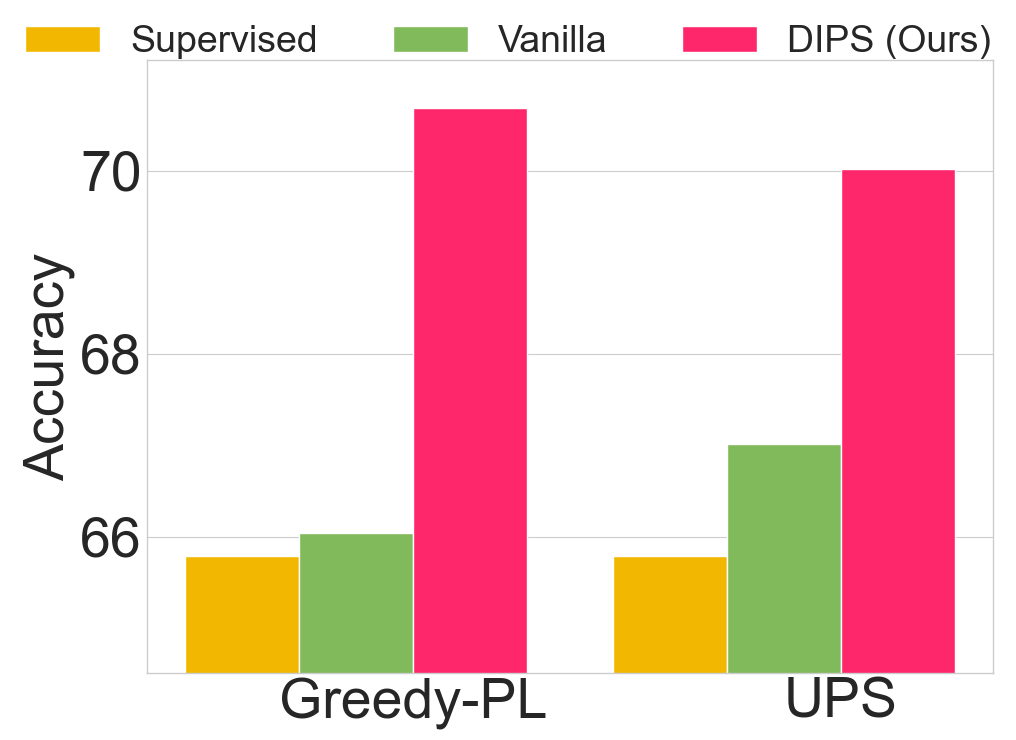

In [5]:

def plot_results(results_dfs, metainfo_list):
    import numpy as np
    import matplotlib.pyplot as plt

    #plt.style.use(['science', 'ieee', "no-latex"])
    plt.style.use('seaborn-whitegrid')
    # Create a figure object with four subplots
    fig, axs = plt.subplots(nrows=1, ncols=len(results_dfs), figsize=(10, 7))
    # Add in red line and rectangle on top
    
    for i, df in enumerate(results_dfs):
        
        ax= axs
    
        data = df

        # Indices for the bar plot
        width = 0.2

        # Extract the means and standard errors for each method
        supervised_mean = data['supervised_learning_accuracy']['acc_mean']
        supervised_se = data['supervised_learning_accuracy']['acc_se']

        # ups
        ups_vanilla_mean = data['ups']['vanilla_mean']
        ups_vanilla_se = data['ups']['vanilla_se']
        ups_dips_full_mean = data['ups']['dips_full_mean']
        ups_dips_full_se = data['ups']['dips_full_se']

        # pseudo
        pseudo_vanilla_mean = data['pseudo']['vanilla_mean']
        pseudo_vanilla_se = data['pseudo']['vanilla_se']
        pseudo_dips_full_mean = data['pseudo']['dips_full_mean']
        pseudo_dips_full_se = data['pseudo']['dips_full_se']


        vanilla_means = [pseudo_vanilla_mean, ups_vanilla_mean]#,  flex_vanilla_mean, sla_vanilla_mean, csa_vanilla_mean]
        vanilla_se = [pseudo_vanilla_se,  ups_vanilla_se]#,  flex_vanilla_se, sla_vanilla_se, csa_vanilla_se]

        dips_full_means = [pseudo_dips_full_mean, ups_dips_full_mean]#, flex_dips_full_mean, sla_dips_full_mean, csa_dips_full_mean]
        dips_full_se = [pseudo_dips_full_se, ups_dips_full_se]#,  flex_dips_full_se,   sla_dips_full_se, csa_dips_full_se]

        supervised_means = [supervised_mean] * len(vanilla_means)
        supervised_se = [supervised_se] * len(vanilla_se)


        ind = np.arange(len(vanilla_means))* 0.75

        supervised_color = '#F2B701' #yellow
        vanilla_color =  '#80BA5A' #green 
        dips_color = '#FF276B' #'#E73F74' #red

        rects0 = ax.bar(ind - 3*width/2, supervised_means, width,label='Supervised', color=supervised_color, alpha=1, edgecolor="white",)
        rects1 = ax.bar(ind - width/2, vanilla_means, width , label='Vanilla', color=vanilla_color, alpha=1, edgecolor="white",)
        rects2 = ax.bar(ind + width/2, dips_full_means, width, label='DIPS (Ours)', color=dips_color, edgecolor="white",)

        fontsize = 40
        # Add some text for labels, title, and custom x-axis tick labels
        ax.set_ylabel('Accuracy', fontsize=fontsize)

        ax.set_xticks(ind)
        ax.set_xticklabels(('Greedy-PL', 'UPS'), fontsize=fontsize)
        
        ax.tick_params(axis="both", which="major", labelsize=fontsize)

        # Calculate min and max values with a margin
        min_value = np.min(vanilla_means + dips_full_means) - np.max(vanilla_se + dips_full_se)-1 
        max_value = np.max(vanilla_means + dips_full_means) + np.max(vanilla_se + dips_full_se) 

        # Set ylim based on the calculated min and max values
        ax.set_ylim([min_value, max_value])
 
        ax.grid(axis='x', alpha=0)
    handles, labels = axs.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, borderaxespad=0, frameon=False, fontsize=27)
    fig.tight_layout()

   

    plt.show()

plot_results(results_dfs = [results], metainfo_list='US-UK')